<a href="https://colab.research.google.com/github/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/Project_3_Natural_Language_Processing_with_Reddit_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id = 'section_0'><a/>
# 0.0 Function Creation
___

In [77]:
# Platform Interface
import time
from time import sleep
import requests
import pickle

import pandas as pd
import numpy as np
import random

# Visualisation Libraries
# !pip install --upgrade --quiet witwidget lime
# import lime
# import shap
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

# ML Libraries
from nltk.tokenize import word_tokenize , sent_tokenize , RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix , plot_roc_curve
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

pd.set_option('display.max_colwidth' , 300)

In [2]:
def red_scrap(title):
    url = 'https://api.pushshift.io/reddit/search/submission'
    df_load = []
    params = {
        'subreddit': title,
        'size' : 100,
        'before': None
    }
    for i in range(15):
        # Access Reddit API
        res = requests.get(url,params)
        data = res.json()
        posts = data['data']
        
        
        df_new = pd.DataFrame(posts)
        df_load.append(df_new)
        
        # Initiating new time stamp (100th position of the 100 size) for before in params
        params['before'] = df_new['created_utc'][99]
        
        # Extract to CSV
        df = pd.concat(df_load, ignore_index = True)
        df.to_csv(f'{title}.csv')
        time.sleep(10)
        print(f'{i+1} Iterations completed')
        
    return df

In [3]:
def date_conversion(df , column):

    time_value = []
    for value in df[column]:
        time_value.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(value)))
        
    df[column] = time_value
    df[[column]] = df[[column]].astype('datetime64[ns]')
    return df

In [4]:
def eval_classification(y_true , y_pred):

    from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

    # Define Scoring variables
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    f1_score = f1_score(y_true , y_pred)

    score_dict = {'Accuracy' : accuracy,
                'Precision' : precision,
                'Recall' : recall,
                'F1 Score' : f1_score}

    return score_dict

In [5]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name +'/' + experiment_name +'/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

In [6]:
# df_fakenews = red_scrap('fakenews')

In [7]:
# df_worldnews = red_scrap('worldnews')

In [8]:
tf.config.list_physical_devices('GPU')
!nvidia-smi

Sun Sep 12 18:04:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a id = 'section_1'><a/>
# 1.0 Data Exploration
___
[(back to top)](#content)

In [9]:
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv

--2021-09-12 18:04:39--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3523846 (3.4M) [text/plain]
Saving to: ‘fakenews.csv.1’

fakenews.csv.1      100%[===================>]   3.36M  --.-KB/s    in 0.09s   

2021-09-12 18:04:42 (38.4 MB/s) - ‘fakenews.csv.1’ saved [3523846/3523846]

--2021-09-12 18:04:42--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP r

In [10]:
# Fake News Reddit
df_fakenews = pd.read_csv('/content/fakenews.csv')
df_fakenews = df_fakenews[['title' , 'subreddit' , 'created_utc']]
df_fakenews = date_conversion(df_fakenews , 'created_utc')

# World News Reddit
df_worldnews = pd.read_csv('/content/worldnews.csv')
df_worldnews = df_worldnews[['title' , 'subreddit' , 'created_utc']]
df_worldnews = date_conversion(df_worldnews , 'created_utc')

In [11]:
print(f'No. of Fakenews Datasets : {len(df_fakenews)}')
print(f'Shape of Fakenews Datasets : {df_fakenews.shape}')

print(f'No. of World News Datasets : {len(df_worldnews)}')
print(f'Shape of World News Datasets : {df_worldnews.shape}')

No. of Fakenews Datasets : 1500
Shape of Fakenews Datasets : (1500, 3)
No. of World News Datasets : 1400
Shape of World News Datasets : (1400, 3)


### 1.1 Checking for Duplicates and Null
___

In [12]:
print(f'No. of Duplicate Cell : {df_fakenews.duplicated().sum()}')
print(f'No. of Null Cell : {df_fakenews.isnull().sum().sum()}')
df_fakenews.drop_duplicates(inplace = True)
print(f'No. of Duplicate Cell After Remove Duplicate : {df_fakenews.duplicated().sum()}')

No. of Duplicate Cell : 1
No. of Null Cell : 0
No. of Duplicate Cell After Remove Duplicate : 0


In [13]:
print(f'No. of Duplicate Cell : {df_worldnews.duplicated().sum()}')
print(f'No. of Null Cell : {df_worldnews.isnull().sum().sum()}')

No. of Duplicate Cell : 0
No. of Null Cell : 0


### 1.2 Visualing Some Random Text
___

In [14]:
# Visualing Some Random Post from Fake News
random_sentences = random.sample(df_fakenews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 Calling Everything Fake News
1 Professor Fired For Fake Chrloroquine Data, &amp; USA COVID Response By The Numbers
2 US Launching Digital Dollar to Combat Digital Yuan
3 Maradona : Donald Trump Mistook Him For Madonna?
4 CNN Tells Viewers to Take Trump’s ‘Hoax’ Comment ‘How You Wish’
5 Don’t think this is true? Coffee is a cash crop and does not directly benefit a third world community, rather stripping land of rich soil while product is sent out for Western society to enjoy.
6 The Misinformation Age and The Orwellian Society
7 We need to stop agendas to separate us, this is blatant bullshit
8 CNN builds a wall around their HQ.
9 Made another post exploring the site known as GlobalResearch.ca, examining their credibility, reporting and journalistic style, and the possibility of their being a tool or assisting in Russian Information Warfare


In [15]:
# Visualing Some Random Post from World News
random_sentences = random.sample(df_worldnews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 France could access Australian military sites as countries look to boost ties. French warships and troops would be given guaranteed access to Australian naval bases and military sites under a proposal being discussed by both countries
1 Romania lurches into another political crisis as Florin Citu clings to power
2 Apapa Customs generate N526 bln in 8-month, seize 56 containers of illicit drugs
3 Drug-Device Combination Products Market Report, Growth Analysis 2021: Impact of COVID-19, Business Insights of Leading Players, Segments and Emerging Technologies 2027
4 Pantelleria tornado: Two dead and nine injured on Italian island south of Sicily | World News
5 Air Incursions Over the Taiwan Strait (18 September 2020)
6 Chinese Ambassador ‘Likes’ an X-Rated Video. Awkward.
7 Putin and Lukashenko move to integrate economies of Russia and Belarus
8 Huawei masters the folding phone formula
9 Belarus, Russia ready to develop political integration if people desire - say Lukashenko


# 2.0 Data Cleaning and Preprocessing
___

In [16]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

port_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.1 TextVectorizer Input and Visualize Random Sentence
___

In [17]:
'''
1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
'''
random_sentences = random.sample(df_fakenews['title'].to_list() , 3)

for sentence in random_sentences:
    
    # Print Before Split
    print('Original Sentence                : ' , sentence)

    # Remove Numeric Number , lower words
    regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
    sent_split = regex_token.tokenize(sentence.lower())
    print('Remove Numeric , lowercase       : ' , sent_split)
    
    # Stripped the Punctuation
    sent_split = [word for word in sent_split if word not in (string.punctuation)]
    print('Remove Punctuation               : ' , sent_split)

    # Remove Stop words
    sent_split = [word for word in sent_split if word not in (stop_words)]
    print('Remove Stop words                : ' , sent_split)

    # Stem the words and joint back  
    joint = ' '.join([port_stemmer.stem(word) for word in sent_split])
    print('Stem the words & joint the words : ' , joint)
    print('-----------------------------------------')
    

Original Sentence                :  Alex Jones ordered to stop selling fake coronavirus cures
Remove Numeric , lowercase       :  ['alex', 'jones', 'ordered', 'to', 'stop', 'selling', 'fake', 'coronavirus', 'cures']
Remove Punctuation               :  ['alex', 'jones', 'ordered', 'to', 'stop', 'selling', 'fake', 'coronavirus', 'cures']
Remove Stop words                :  ['alex', 'jones', 'ordered', 'stop', 'selling', 'fake', 'coronavirus', 'cures']
Stem the words & joint the words :  alex jone order stop sell fake coronaviru cure
-----------------------------------------
Original Sentence                :  Fake News? Real News? Who Decides?
Remove Numeric , lowercase       :  ['fake', 'news', 'real', 'news', 'who', 'decides']
Remove Punctuation               :  ['fake', 'news', 'real', 'news', 'who', 'decides']
Remove Stop words                :  ['fake', 'news', 'real', 'news', 'decides']
Stem the words & joint the words :  fake news real news decid
----------------------------------

### 2.2 Preprocess Function for data
___

In [18]:
def preprocessing(df , col):
    
    sentence_process = []
    for sentence in df[col]:
               
        # Remove Numeric Number , lower words
        regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
        sent_split = regex_token.tokenize(sentence.lower())
        
        # Stripped the Punctuation
        sent_split = [word for word in sent_split if word not in (string.punctuation)]

        # Remove Stop words
        sent_split = [word for word in sent_split if word not in (stop_words)]

        # Stem the words and joint back  
        joint = ' '.join([port_stemmer.stem(word) for word in sent_split])        
    
        sentence_process.append(joint)
    
    df[col] = sentence_process

In [19]:
preprocessing(df_fakenews , 'title')

In [20]:
df_fakenews.head()

,title,subreddit,created_utc
0,research show great awoken media preced trump outlast opinion,fakenews,2021-09-11 13:37:46
1,get paid china stir panic,fakenews,2021-09-10 18:52:00
2,fact check journalist spread misinform wi spa,fakenews,2021-09-10 16:25:26
3,afghani central bank governor imag goe viral real asia market,fakenews,2021-09-10 13:48:40
4,stori mike emm real,fakenews,2021-09-08 21:29:04


In [21]:
preprocessing(df_worldnews , 'title')

In [22]:
df_worldnews.head()

,title,subreddit,created_utc
0,mari trump say disgrac uncl spend comment box match,worldnews,2021-09-12 06:20:04
1,next fast food chicken sandwich war may fake one,worldnews,2021-09-12 06:11:44
2,revis belgium histori call first ebola outbreak congo,worldnews,2021-09-12 06:00:46
3,democrat build big edg earli vote,worldnews,2021-09-12 05:59:43
4,ch51 ch51,worldnews,2021-09-12 05:59:42


### 2.3 Removing Data Leakage
___

In [23]:
# DF Fake News
print('Data Count Before removal leaked words:' , len(df_fakenews))
df_fakenews = df_fakenews.loc[~df_fakenews['title'].str.contains('fake|news|new')]
df_fakenews.head()
print('Data Count After removal leaked words:' , len(df_fakenews))

Data Count Before removal leaked words: 1499
Data Count After removal leaked words: 994


In [24]:
print('Data Count Before removal leaked words:' , len(df_worldnews))
df_worldnews = df_worldnews.loc[~df_worldnews['title'].str.contains('world|news|new')]
df_worldnews.head()
print('Data Count After removal leaked words:' , len(df_worldnews))

Data Count Before removal leaked words: 1400
Data Count After removal leaked words: 1237


### 2.4 Merging Datasets
___

In [25]:
df_main = pd.concat([df_fakenews , df_worldnews])
df_main.drop('created_utc' , inplace=True , axis = 1)

print(f'No. of Combined Datasets : {len(df_main)}')
print(f'Shape of Combined Datasets : {df_main.shape}')
print(f'SIze of Combined Datasets : {df_main.size}')

No. of Combined Datasets : 2231
Shape of Combined Datasets : (2231, 2)
SIze of Combined Datasets : 4462


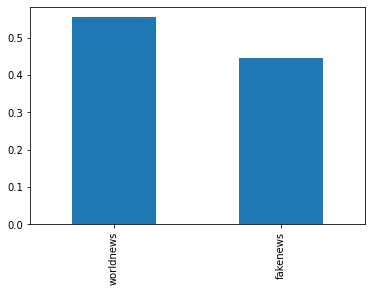

In [26]:
df_main['subreddit'].value_counts(normalize = True).plot(kind = 'bar');

In [27]:
dict_reddit = {'fakenews' : 0,
         'worldnews' : 1}

df_main['subreddit'] = df_main['subreddit'].map(dict_reddit)

### 2.5 Visualising Popular Words
___

In [28]:
# Inistantiating Count Vectorizer
cvec = CountVectorizer(ngram_range=(1,3))
cvec.fit(df_main['title'])
main = cvec.transform(df_main['title'])


cvec_fake = CountVectorizer(ngram_range = (1,3))
cvec_fake.fit(df_main[df_main['subreddit'] == 0]['title'])
fake = cvec_fake.transform(df_main[df_main['subreddit'] == 0]['title'])

cvec_world = CountVectorizer(ngram_range = (1,3))
cvec_world.fit(df_main[df_main['subreddit'] == 1]['title'])
world = cvec_world.transform(df_main[df_main['subreddit'] == 1]['title'])

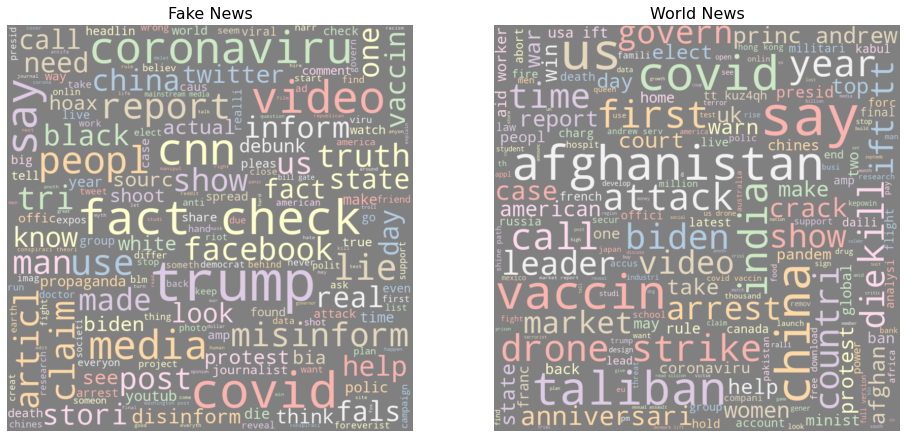

In [29]:
# Word cloud for news

word_fake = ' '.join([word for word in df_main[df_main['subreddit'] == 0]['title']])
word_world = ' '.join([word for word in df_main[df_main['subreddit'] == 1]['title']])

wordcloud_fake = WordCloud(width= 800, 
                          height= 800,
                          max_font_size = 110,
                          collocations = True,
                          background_color = 'grey',
                          colormap= 'Pastel1').generate(word_fake)

wordcloud_world = WordCloud(width= 800, 
                            height= 800,
                            max_font_size = 110,
                            collocations = True,
                            background_color = 'grey',
                            colormap= 'Pastel1').generate(word_world)                      

plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Fake News' , fontsize = 16)

plt.subplot(1,2,2)
plt.imshow(wordcloud_world, interpolation='bilinear')
plt.axis("off")
plt.title('World News' , fontsize = 16);

In [30]:
# Interestingly the vocab from each DF summed up is not equal to the vocab from the merged DF
df_main_vocab = pd.DataFrame(main.todense(),
                             columns = cvec.get_feature_names())

df_fake_vocab = pd.DataFrame(fake.todense(),
                             columns = cvec_fake.get_feature_names())

df_world_vocab = pd.DataFrame(world.todense(),
                              columns = cvec_world.get_feature_names())

print(f'DF Shape for Main Vocab :' , df_main_vocab.shape)
print(f'DF Shape for fakenews Vocab  :' , df_fake_vocab.shape)
print(f'DF Shape for worldnews Vocab  :' , df_world_vocab.shape)

DF Shape for Main Vocab : (2231, 29187)
DF Shape for fakenews Vocab  : (994, 12437)
DF Shape for worldnews Vocab  : (1237, 18158)


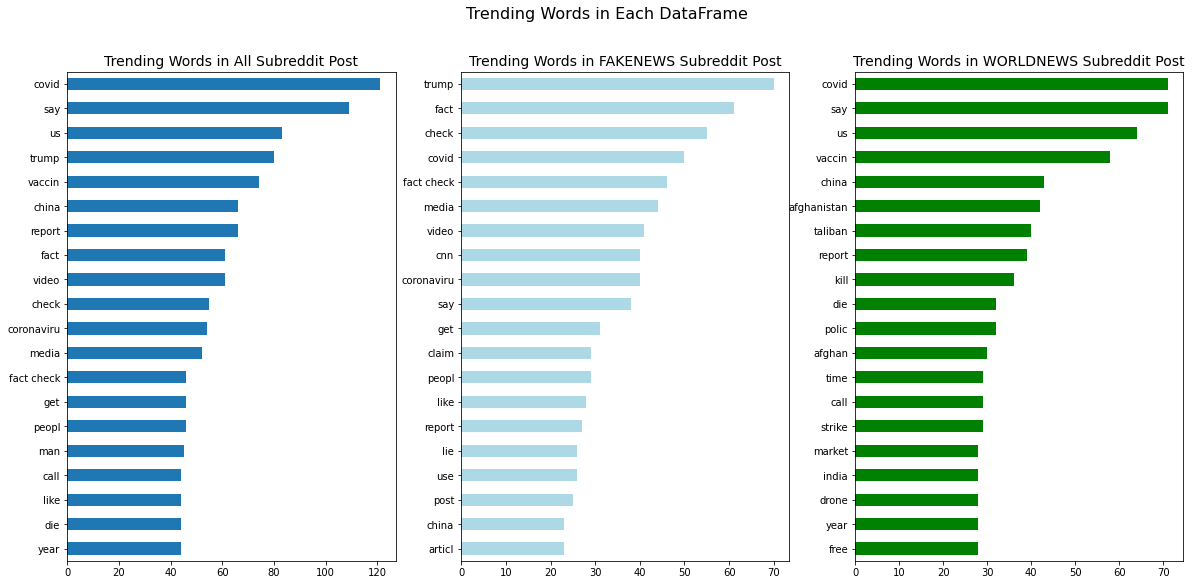

In [31]:
fig , ax = plt.subplots(1 , 3 , figsize = (20,9))

df_main_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[0])
ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

df_fake_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[1] , color = 'lightblue')
ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

df_world_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[2] , color = 'green')
ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

plt.suptitle('Trending Words in Each DataFrame' , fontsize = 16);

#3.0 Modelling with Random Forest

In [32]:
X = df_main['title']
y = df_main['subreddit']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 ,random_state=42 , stratify = y)

In [95]:
%%time
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())
])

# rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
#                  'min_samples_leaf' : np.arange(1, 5 , 1),
#                  'n_estimators' : np.arange(50 , 80 , 10),
#                  'max_features' : ['log2' , 'sqrt' , 'auto'],
#                  'max_depth' : [None , 3 , 5]}

param_grid = {'vect__ngram_range' : [(1,1) , (1,2) , (1,3)],
              'tfidf__smooth_idf' : [True , False],
              'tfidf__sublinear_tf' : [True , False],
              'model__min_samples_split' : np.arange(2 , 10 , 2),
              'model__min_samples_leaf' : np.arange(1 , 5 , 1),
              'model__n_estimators' : np.arange(50 , 80 , 10),
              'model__max_features' : ['log2' , 'sqrt' , 'auto'],
              'model__max_depth' : [3,5,7]              
}

# Fitting the model
model = GridSearchCV(estimator = pipe,
                     param_grid = param_grid,
                     cv = 5,
                     n_jobs =-1)

model.fit(X_train , y_train)
# # Model Prediction
y_pred = model.predict(X_test)

CPU times: user 4min 26s, sys: 8.77 s, total: 4min 34s
Wall time: 1h 6min 31s


In [99]:
model.best_params_

{'model__max_depth': 7,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 6,
 'model__n_estimators': 70,
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'vect__ngram_range': (1, 1)}

In [105]:
# Saving the Model
pickle.dump(model , open('RFC_model.pkl' , 'wb'))

In [121]:
# !wget https://github.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/saved_models/RFC_model.pkl

### 3.0.5 Experimenting with New GridSearch parameters
___

In [164]:
%%time
pipe = Pipeline([('vect', CountVectorizer(min_df = 0.01 , max_df = 0.9)),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())
])

# rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
#                  'min_samples_leaf' : np.arange(1, 5 , 1),
#                  'n_estimators' : np.arange(50 , 80 , 10),
#                  'max_features' : ['log2' , 'sqrt' , 'auto'],
#                  'max_depth' : [None , 3 , 5]}

param_grid = {'vect__min_df' : np.arange(0.01 , 1.05 , 0.05),
              'model__min_samples_split' : np.arange(1 , 5 , 1),
              'model__min_samples_leaf' : np.arange(6 , 8 , 1),
              'model__n_estimators' : np.arange(90 , 120 , 10),
              'model__max_features' : ['sqrt'],
              'model__max_depth' : [None]              
}

# Fitting the model
model_2 = GridSearchCV(estimator = pipe,
                       param_grid = param_grid,
                       cv = 5,
                       n_jobs =-1)

model_2.fit(X_train , y_train)
# # Model Prediction
y_pred_2 = model_2.predict(X_test)

CPU times: user 6.41 s, sys: 379 ms, total: 6.79 s
Wall time: 1min 46s


In [165]:
model_2.best_params_

{'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 7,
 'model__min_samples_split': 4,
 'model__n_estimators': 90,
 'vect__max_df': 1.0}

In [68]:
model_RFC = Pipeline([('vect', CountVectorizer(min_df = 10 , max_df = 1.0 , ngram_range = (1,3))),
                      ('tfidf', TfidfTransformer('l2')),
                      ('model', RandomForestClassifier(min_samples_split=4,
                                                       min_samples_leaf = 6,
                                                       n_estimators = 90,
                                                       max_features = 'sqrt'))
])
                      
model_RFC.fit(X_train , y_train)
model_RFC_pred = model_RFC.predict(X_test)

{'Accuracy': 0.7069351230425056,
 'F1 Score': 0.7729636048526863,
 'Precision': 0.6778115501519757,
 'Recall': 0.8991935483870968}

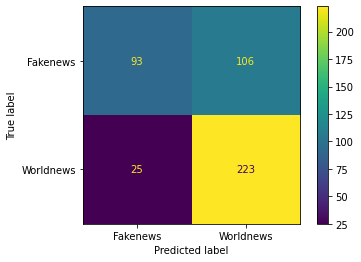

In [69]:
plot_confusion_matrix(model_RFC , X_test , 
                      y_test , 
                      values_format = '.4g',
                      display_labels = ['Fakenews' , 'Worldnews']);

eval_classification(y_true=y_test , y_pred = model_RFC_pred)

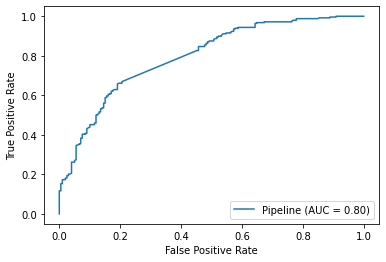

In [70]:
plot_roc_curve(model_RFC , X_test , y_test)

### 3.1 Evaluating Model Score
___

In [98]:
eval_classification(y_true=y_test , y_pred = y_pred)

{'Accuracy': 0.6040268456375839,
 'F1 Score': 0.7264296754250387,
 'Precision': 0.573170731707317,
 'Recall': 0.9915611814345991}

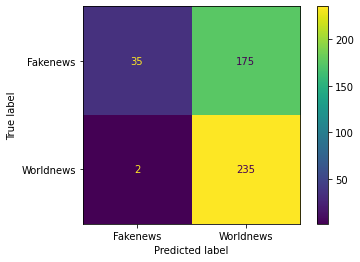

In [102]:
plot_confusion_matrix(model , X_test , 
                      y_test , 
                      values_format = '.4g',
                      display_labels = ['Fakenews' , 'Worldnews']);

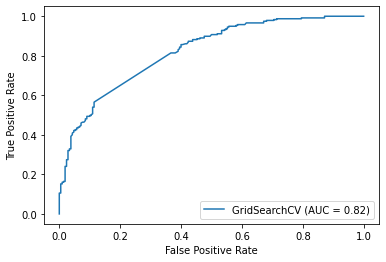

In [103]:
plot_roc_curve(model , X_test , y_test)

### 3.2 Visualing Most Wrongly Predicted Reddit Post
___

In [71]:
y_proba = model_RFC.predict_proba(X_test)
fakenews_prediction = [y_proba[i][0] for i in range(len(X_test))]

In [73]:
df_prediction  = pd.DataFrame({'Title' : X_test,
                              'Target' : y_test,
                              'Prediction' : model_RFC_pred,
                              'Fakenews_prediction' : fakenews_prediction})

In [74]:
# Visualing Most Wrong World News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Fakenews_prediction' , ascending = False)
df_most_right_wrong.tail(10)

,Title,Target,Prediction,Fakenews_prediction
462,hate year old sometim,0,1,0.203205
154,north korea win world cup group stage,0,1,0.203001
1486,misconcept cast system india,0,1,0.173305
834,rape case hyderabad pakistan viral hyderabad india,0,1,0.169771
1304,microsoft ceo nadella criticis india citizenship law,0,1,0.166237
695,women leader better control pandem,0,1,0.156548
819,beidou give huawei phone free call internet,0,1,0.151927
1085,wonder solut could,0,1,0.150638
55,googl time crystal could greatest scientif achiev lifetim,0,1,0.143914
261,pocahonta first winner hunger game,0,1,0.104913


# 4.0 Modelling with TF Universal Encoder
___

`turning data into numbers (textvectorisation , embedding)` -> `building a model` -> `training the model`

In [211]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
import tensorflow_hub as hub

In [123]:
max_vocab_length = 3000 # We have around 4848 from above visualisation
max_length = 30

text_vectorisation = TextVectorization(max_tokens = max_vocab_length,
                                       output_mode = 'int',
                                       output_sequence_length = None,
                                       pad_to_max_tokens = True)

In [213]:
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [ ]:
random_sentences = random.sample(df_main['title'].to_list() , 3)

for sentence in random_sentences:
  print(sentence)
  print(embed([sentence]))
  print('------------------------------------------------')

In [216]:
# Create a Keras Layer using Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'tf_model')

In [235]:
tf_model = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(1 , activation = 'sigmoid')
])

tf_model.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics = 'accuracy')

In [236]:
tf_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_model (KerasLayer)        (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [264]:
history_tf = tf_model.fit(X_train,
                        y_train,
                        epochs = 5,
                        validation_data = (X_test , y_test),
                        callbacks = [create_tensorboard_callback('model_log' , 'tf_model')])

Saving Tensorboard log files to model_log/tf_model/20210912-180148
Epoch 1/5
56/56 [==============================] - 2s 39ms/step - loss: 0.2907 - accuracy: 0.8845 - val_loss: 0.4702 - val_accuracy: 0.7718
Epoch 2/5
56/56 [==============================] - 1s 19ms/step - loss: 0.2534 - accuracy: 0.9070 - val_loss: 0.4778 - val_accuracy: 0.7785
Epoch 3/5
56/56 [==============================] - 1s 21ms/step - loss: 0.2140 - accuracy: 0.9254 - val_loss: 0.4927 - val_accuracy: 0.7964
Epoch 4/5
56/56 [==============================] - 1s 18ms/step - loss: 0.1789 - accuracy: 0.9439 - val_loss: 0.5180 - val_accuracy: 0.7808
Epoch 5/5
56/56 [==============================] - 1s 21ms/step - loss: 0.1407 - accuracy: 0.9608 - val_loss: 0.5329 - val_accuracy: 0.7808


In [ ]:
tf_model_pred = tf_model.predict(X_test)
tf_model_pred

In [266]:
eval_classification(y_test , tf.squeeze(tf.round(tf_model_pred)))

{'Accuracy': 0.7807606263982103,
 'F1 Score': 0.7999999999999999,
 'Precision': 0.7747035573122529,
 'Recall': 0.8270042194092827}

# 5.0 LSTM Model
___

In [78]:
max_vocab_length = 10000  # Max number of words in our vocab
max_length = 30 # max length our sequence will be (In this case the sequence is a tweet)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length,
                                    pad_to_max_tokens = True)

embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      input_length = max_length)

inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64 , return_sequences = True))(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(32))(x)
print(x.shape)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
print(x.shape)

lstm_model = tf.keras.Model(inputs , outputs , name = 'lstm_bidrection')

(None, 30, 128)
(None, 30, 128)
(None, 64)
(None, 64)


In [79]:
lstm_model.summary()

Model: "lstm_bidrection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,420,097
Trainable params: 1,420,097
Non-trainable params: 0
_________________________________________

In [80]:
lstm_model.compile(optimizer = tf.keras.optimizers.Adam(),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = 'accuracy')

In [ ]:
history_lstm = lstm_model.fit(X_train,
                              y_train,
                              epochs = 5,
                              validation_data = (X_test , y_test),
                              callbacks = [create_tensorboard_callback('model_log' , 'lstm_model')])